In [1]:
import numpy as np
import pandas as pd
import ta
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
dd = pd.read_excel("Index/data.xlsx")
dd = dd.set_index('Date')
dd =dd.drop(columns='Unnamed: 0')

In [3]:
def Calculate_TA_and_label(dd,c):
    dd['Highest_Close']=dd['High'].rolling(window=26).max()
    dd['Lowest_Close']=dd['Low'].rolling(window =26).min()
    dd['RSI']=ta.momentum.RSIIndicator(dd['Close'], window  = 10, fillna = False).rsi()
    dd['MACD']=ta.trend.macd_diff(dd['Close'], window_slow=26,window_fast=12,fillna= False)
    dd['MA_slow']=((dd['Close']+dd['Low']+dd['High'])/3).rolling(window=30).mean()
    dd['MA'] = ((dd['Close']+dd['Low']+dd['High'])/3).rolling(window=20).mean()
    dd['Volume_AVG'] = dd['Volume'].rolling(window=30).mean()
    dd['Low_band'] = dd['Low'].rolling(window=9).mean()
    dd['High_band'] = dd['High'].rolling(window=9).mean()
    dd['Close_only'] = dd['Close'].rolling(window=20).mean()
    dd['Sto_RSI']= (dd['RSI']-dd['RSI'].rolling(window=14).min())/(dd['RSI'].rolling(window=14).max()-dd['RSI']+0.1)
    dd['MA_RSI']= dd['RSI'].rolling(window=14).mean()
    dd['EMA']=ta.trend.ema_indicator(dd['Close'], window = 20, fillna = False)
    #dd['CCI'] = ta.trend.cci(dd['High'],dd['Low'],dd['Close'], window=25,constant=0.015,fillna=False)
    #dd['ROCI']=ta.momentum.ROCIndicator(dd['Close'], window = 12, fillna = False).roc()
    dd['TSI']=ta.momentum.TSIIndicator(dd['Close'], window_slow = 25, window_fast = 13, fillna = False).tsi()
    #dd['MACD_signal']=ta.trend.macd_signal(dd['Close'], window_slow=26, window_fast=12, window_sign=9, fillna=False)
    #dd['KAMA']=ta.momentum.KAMAIndicator(dd['Close'], window = 10, pow1 = 2, pow2 = 30, fillna = False).kama()
    dd['MFI']=ta.volume.MFIIndicator(dd['High'],dd['Low'],dd['Close'],dd['Volume'], window = 18, fillna = False).money_flow_index()
    dd['BB_high']=ta.volatility.BollingerBands(dd['Close'], window = 20, window_dev = 2, fillna = False).bollinger_hband()
    dd['BB_low']=ta.volatility.BollingerBands(dd['Close'], window = 20, window_dev = 2, fillna = False).bollinger_lband()
    dd['BB_high_RSI']=ta.volatility.BollingerBands(dd['RSI'], window = 20, window_dev = 2, fillna = False).bollinger_hband()
    dd['BB_low_RSI']=ta.volatility.BollingerBands(dd['RSI'], window = 20, window_dev = 2, fillna = False).bollinger_lband()
    dd['BB_high_vol']=ta.volatility.BollingerBands(dd['Volume'], window = 20, window_dev = 1.5, fillna = False).bollinger_hband()
    dd['BB_low_vol']=ta.volatility.BollingerBands(dd['Volume'], window = 20, window_dev = 1.5, fillna = False).bollinger_lband()
    #dd['WMA']=ta.trend.WMAIndicator(dd['Close'], window = 20, fillna = False).wma()
    # đoạn này là bắt đầu khoai r vì nhìn thì nhiều nhưng thực ra tất cả đều không có quá khó hiểu chỉ là bản chất nó khá là rắc rối :Vvv
    # tớ sẽ giải thích 1 vài chỉ báo trong đống này
    dd['ATR'] =ta.volatility.AverageTrueRange(dd['High'],dd['Low'],dd['Close'],window=14,fillna= False).average_true_range()
    dd['High_Low'] = (dd['High']+dd['Low'])/2
    dd['upper_band'] = dd['High_Low']+2*dd['ATR']
    dd['lower_band'] = dd['High_Low']-2*dd['ATR']
    dd["Target"] = dd["Close"].rolling(2).apply(lambda x: 1 if x.iloc[1] > x.iloc[0]+c else -1 if x.iloc[1] < x.iloc[0]-c else 0).shift(-1)
    dd["Distance"] = dd["Close"].rolling(2).apply(lambda x :round(x.iloc[1] - x.iloc[0],2)).shift(-1)
    final_band_upper=final_band_lower=super_trend=[0 for i in range(len(dd))]
    final_band_upper[0] = dd['upper_band'].iloc[0]
    final_band_lower[0] = dd['lower_band'].iloc[0]
    super_trend[0]= final_band_lower[0]
    for i in range(1,len(dd)) :
        if dd['upper_band'].iloc[i]< final_band_upper[i-1] or dd['Close'].iloc[i-1]>final_band_upper[i-1]:
            final_band_upper[i] = dd['upper_band'].iloc[i]
        else: final_band_upper[i] = final_band_upper[i-1]
        if dd['lower_band'].iloc[i]> final_band_lower[i-1] or dd['Close'].iloc[i-1]<final_band_lower[i-1]:
            final_band_lower[i] = dd['lower_band'].iloc[i]
        else: final_band_lower[i] = final_band_lower[i-1]
        if super_trend[i-1] == final_band_upper[i-1]:
            super_trend[i] = final_band_upper[i] if dd['Close'].iloc[i]<= final_band_upper[i] else final_band_lower[i]
        if super_trend[i-1] == final_band_lower[i-1]:
            super_trend[i] = final_band_lower[i] if dd['Close'].iloc[i]>= final_band_lower[i] else final_band_upper[i]
    dd['Super_trend']=super_trend
    dd['RSI']=ta.momentum.RSIIndicator(dd['Close'], window  = 10, fillna = False).rsi()
    dd['MA'] = ((dd['Close']+dd['Low']+dd['High'])/3).rolling(window=20).mean()
    dd['BB_high']=ta.volatility.BollingerBands(dd['Close'], window = 20, window_dev = 2, fillna = False).bollinger_hband()
    dd['BB_low']=ta.volatility.BollingerBands(dd['Close'], window = 20, window_dev = 2, fillna = False).bollinger_lband()
    OBV = ta.volume.OnBalanceVolumeIndicator(close=dd['Close'], volume=dd['Volume']).on_balance_volume()
    OBV_EMA = OBV.ewm(span=8).mean()
    dd['OBV_EMA']=0
    dd.loc[OBV_EMA > OBV_EMA.shift(1), 'OBV_EMA'] = 1
    dd.loc[OBV_EMA < OBV_EMA.shift(1), 'OBV_EMA'] = -1
    DPO = ta.trend.DPOIndicator(dd.Close).dpo()
    dd['DPO']=0
    dd.loc[DPO > 0, 'DPO'] = 1
    dd.loc[DPO < 0, 'DPO'] = -1
    MFI = ta.volume.MFIIndicator(dd.High, dd.Low, dd.Close, dd.Volume).money_flow_index()
    dd['MFI']=0
    dd.loc[MFI > 80, 'MFI'] = 1
    dd.loc[MFI < 20, 'MFI'] = -1
    dd['bs']=dd['Close']-dd['Close_vn30']
    return dd

In [4]:
def Sign_signal(Close,MA,High,Low,BB_high,BB_low,RSI,BB_low_RSI,BB_high_RSI,BB_low_vol,BB_high_vol,Volume,MACD,Low_band,Close_only,EMA,MFI,MA_RSI,super_trend,vnindex,vn30,MA_slow,Volume_AVG,DPO,OBV_EMA,Basic):
    Day_Signal=[[] for i in range(len(Close))]
    temp=0
    rs=[]
    for i in range(len(Close)):
        Day_Signal[i].append(sum(RSI[t]>=RSI[t+1]for t in range(i-20,i)))
        Day_Signal[i].append(sum(Close[t]>=Close[t+1] for t in range(i-4,i)))
        Day_Signal[i].append(MA[i]/Close[i])
        Day_Signal[i].append(MA[i]/MA[i-1])
        Day_Signal[i].append(sum(Close[t]>MA[t] for t in range(i-9,i+1)))
        Day_Signal[i].append((BB_high[i]-High[i])/(BB_high[i]-BB_low[i]))
        Day_Signal[i].append((BB_low[i]-Low[i])/(BB_high[i]-BB_low[i]))
        Day_Signal[i].append(Volume[i]/Volume_AVG[i])
        Day_Signal[i].append(sum(MACD[t] for t in range(i-9,i+1)))
        Day_Signal[i].append(sum(Volume[t]>Volume[t-1] for t in range(i-9,i+1)))
        Day_Signal[i].append(RSI[i]/(BB_high_RSI[i]-BB_low_RSI[i]))
        Day_Signal[i].append(vnindex[i]/vnindex[i-3]-vn30[i]/vn30[i-3])
        Day_Signal[i].append(sum(vnindex[j-1]>vnindex[j-2] and vn30[j-1]>vn30[j-2] for j in range(i-20,i+1)))
        Day_Signal[i].append(vn30[i]-vn30[i-1])
        Day_Signal[i].append(DPO[i])
        Day_Signal[i].append(Basic[i])

    return Day_Signal

def Calculate_feature_remove_outlier(dd,c):
    Signal= Sign_signal(dd.Close,dd.MA,dd.High,dd.Low,dd.BB_high,dd.BB_low,dd.RSI,dd.BB_low_RSI,dd.BB_high_RSI,dd.BB_low_vol,dd.BB_high_vol,dd.Volume,dd.MACD,dd.Low_band,dd.Close_only,dd.EMA,dd.MFI,dd.MA_RSI,dd.Super_trend,dd.Close_vnind,dd.Close_vn30,dd.MA_slow,dd.Volume_AVG,dd.DPO,dd.OBV_EMA,dd.bs)
    dd_Signal = pd.DataFrame(Signal,index=dd.index)
    Date = '2022-06-01'
    Date_start = '2018-01-11'
    Date2 ='2022-06-01'
    Date_end = '2024-01-01'
    Train = dd.loc[Date_start:Date]
    Test = dd.loc[Date2:Date_end]
    Signal_Train= dd_Signal.loc[Date_start:Date]
    Signal_Test= dd_Signal.loc[Date2:Date_end]
    Signal_Train_pd =pd.DataFrame(Signal_Train, index = Train.index)
    Signal_Train_pd['Target'] = Train['Target']
    Signal_Train_pd['Distance'] = Train['Distance']
    Signal_Train_pd['Close']=Train['Close']
    Signal_Train_pd = Signal_Train_pd.drop(Signal_Train_pd[abs(Signal_Train_pd['Distance'])>Signal_Train_pd['Close']*c].index)
    label_train = Signal_Train_pd['Target']
    distance_train = Signal_Train_pd['Distance']
    Signal_Train_pd=Signal_Train_pd.drop(columns=['Target','Distance','Close'])
    return Signal_Train_pd,label_train,Signal_Test,Train,Test,Signal_Train

In [5]:
k = 0
h=2
l=0
dd = Calculate_TA_and_label(dd,k/100)
Signal_Train_pd,label_train,Signal_Test,Train,Test,Signal_Train = Calculate_feature_remove_outlier(dd,h)

X = Signal_Train
y = label_train
X_test_final = Signal_Test
y_test_final = Test["Target"]

y[y==0] =1 
y_test_final[y_test_final==0] =1 

/var/folders/yn/x_p7bpbd53x_4p9t5hb2r9140000gn/T/ipykernel_40598/3623002890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_final[y_test_final==0] =1
/var/folders/yn/x_p7bpbd53x_4p9t5hb2r9140000gn/T/ipykernel_40598/3623002890.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_final[y_test_final==0] =1


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [7]:
from sklearn.decomposition import PCA 
pca_12 = PCA(n_components=16, random_state=2023)
pca_12.fit(X_scaled)
X_pca12 = pca_12.transform(X_scaled)

pca_12.explained_variance_ratio_* 100

array([41.97940225, 10.50964143,  8.86688668,  6.29764492,  5.71838627,
        5.05513196,  4.47878825,  3.90787819,  3.32851915,  2.82942415,
        2.15940651,  1.90438062,  1.26595507,  0.94094685,  0.42105795,
        0.33654976])

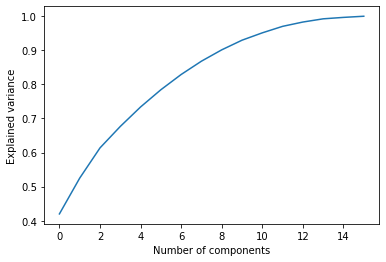

In [8]:
plt.plot(np.cumsum(pca_12.explained_variance_ratio_)) 
plt.xlabel('Number of components') 
plt.ylabel('Explained variance') 
plt.show()

We can see that there are 5 features that hold about 74% variance of the dataset

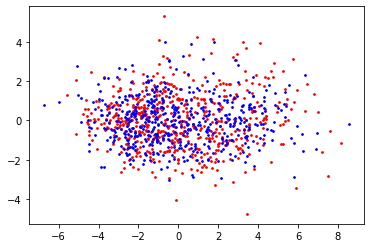

In [9]:
pca_2 = PCA(n_components=2, random_state=2020)
pca_2.fit(X_scaled)
X_pca_2 = pca_2.transform(X_scaled)

plt.scatter(X_pca_2[:,0][y == 1], X_pca_2[:,1][y == 1], s=3, c='r')
plt.scatter(X_pca_2[:,0][y == -1], X_pca_2[:,1][y == -1], s=3, c='b')
plt.show()